# Regression ABC using MDNs
MDN implementation based on this tutorial: https://github.com/hardmaru/pytorch_notebooks/blob/master/mixture_density_networks.ipynb

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss

import os
import sys
sys.path.append(os.path.abspath(os.path.join('..')))
from acm2017_pyabc.examples import tuberculosis
import acm2017_pyabc

from regression_abc import MDN, mdn_loss_function

import torch
from torch.autograd import Variable

## GMM example
Let's first consider the simple example of an equally weighted mixture of Gaussians with equal mean. One of them with a std of 1, the other 0.1.

In [2]:
def simulator(mu):
    if np.random.rand() < 0.5:
        return np.random.normal(mu,1)
    else:
        return np.random.normal(mu,0.1)
    
def posterior(mu):
    return 0.5 * ss.norm.pdf(mu, 0, 1) + 0.5 * ss.norm.pdf(mu, 0, 0.1)

<IPython.core.display.Javascript object>


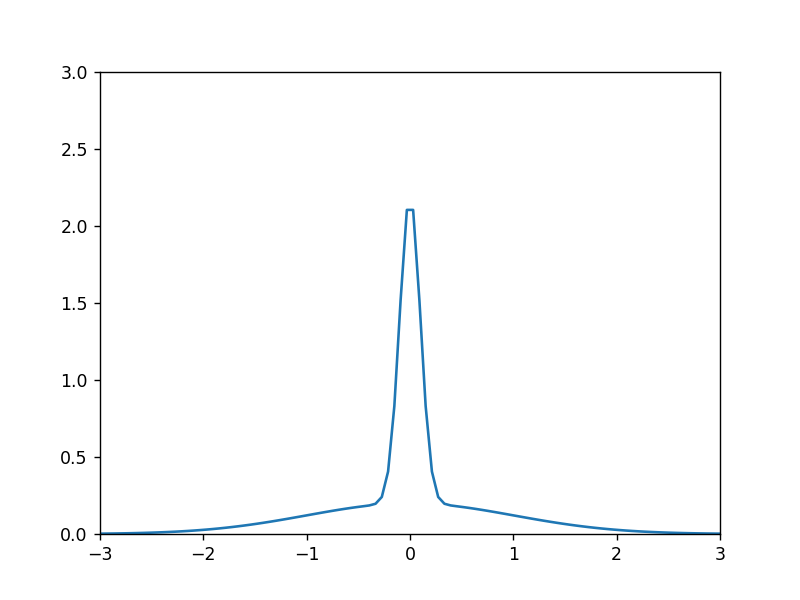

In [3]:
xx = np.linspace(-3,3,100)
plt.figure()
plt.plot(xx, posterior(xx))
plt.xlim((-3,3))
plt.ylim((0,3))
plt.show()

In [23]:
x_obs = 0.0

We use a uniform prior and generate 2500 samples, from which we generate the training set for our MDN.

In [4]:
NSAMPLE = 10_000

theta = np.random.uniform(-2, 4, NSAMPLE)
theta.shape

(10000,)

In [5]:
x_data = np.array([simulator(theta_i) for theta_i in theta])
#x_data = summarize(x)
x_data.shape

(10000,)

Here, we adjust the number of hidden units and mixture components in the MDN

In [6]:
NHIDDEN = 20 # hidden units
KMIX = 2 # number of mixtures

Convert the training examples to torch tensors.

In [7]:
x_train = Variable(torch.from_numpy(x_data.reshape(NSAMPLE, 1)).float())
theta_train = Variable(torch.from_numpy(theta.reshape(NSAMPLE, 1)).float(), requires_grad=False)

<IPython.core.display.Javascript object>


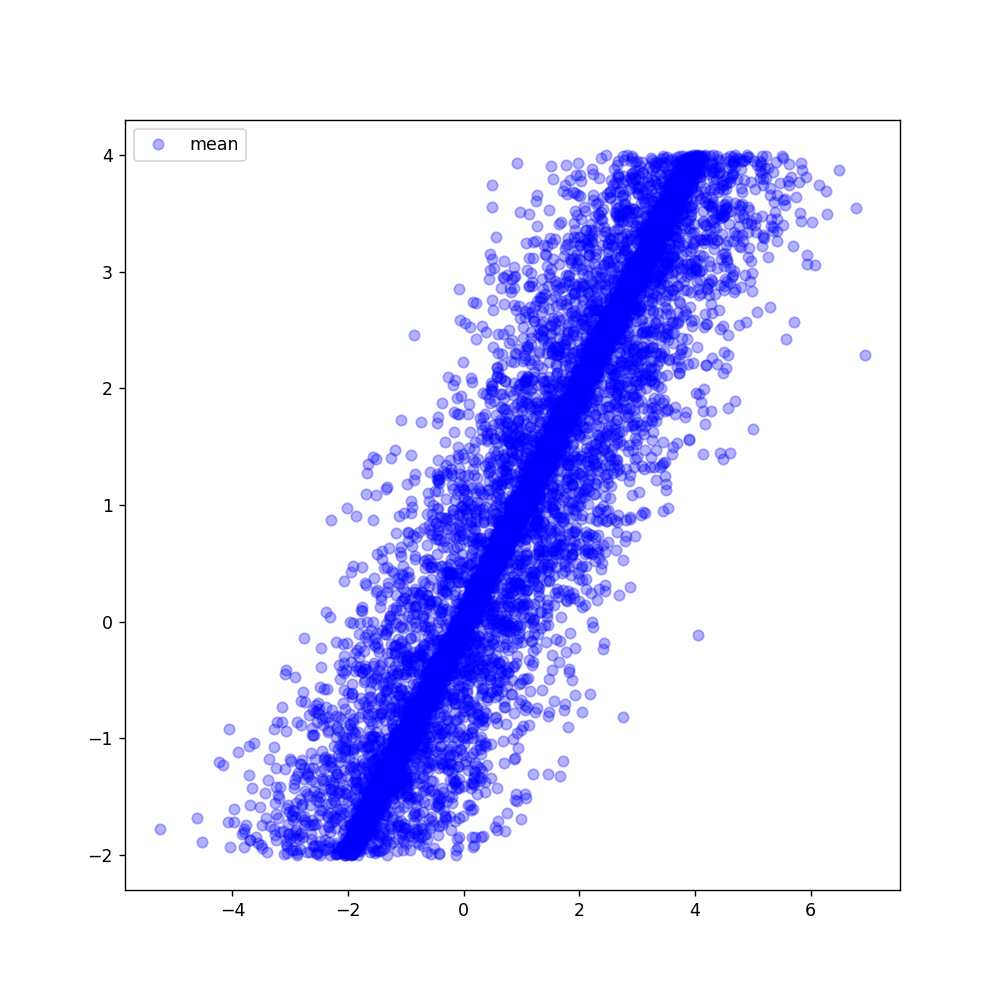

In [8]:
plt.figure(figsize=(8, 8))
plt.plot(x_train.data.numpy()[:,0],theta_train.data.numpy(),'bo', alpha=0.3, label='mean')
#plt.plot(x_train.data.numpy()[:,1],theta_train.data.numpy(),'ro', alpha=0.3, label='std')
plt.legend()
plt.show()

We now define the loss function, which is simply the negative log likelihood of the training data under our model.

In [19]:
model = MDN(hidden_size=NHIDDEN, num_mixtures=KMIX, input_dim=1)

In [20]:
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
for t in range(10000):
    (out_pi, out_sigma, out_mu) = model(x_train)
    loss = mdn_loss_function(out_pi, out_sigma, out_mu, theta_train)
    if (t % 500 == 0):
        print(t, loss.data[0])
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

0 2.818746328353882
500 0.619036078453064
1000 0.5719980001449585
1500 0.5588894486427307
2000 0.5512745380401611
2500 0.5424860715866089
3000 0.5277553200721741
3500 0.5216761231422424
4000 0.5186418890953064
4500 0.5168285369873047
5000 0.5155085325241089
5500 0.514441967010498
6000 0.5135542750358582
6500 0.5128122568130493
7000 0.5121739506721497
7500 0.5115817189216614
8000 0.5109877586364746
8500 0.5104067921638489
9000 0.5098152160644531
9500 0.5093478560447693


In [24]:
x_test = Variable(torch.from_numpy(np.array(x_obs).reshape(1, 1)).float())

In [25]:
xx = np.linspace(-3,3,100)

In [26]:
pdf = model.pdf(x_test, xx)

In [27]:
pdf.shape

(100,)

<IPython.core.display.Javascript object>


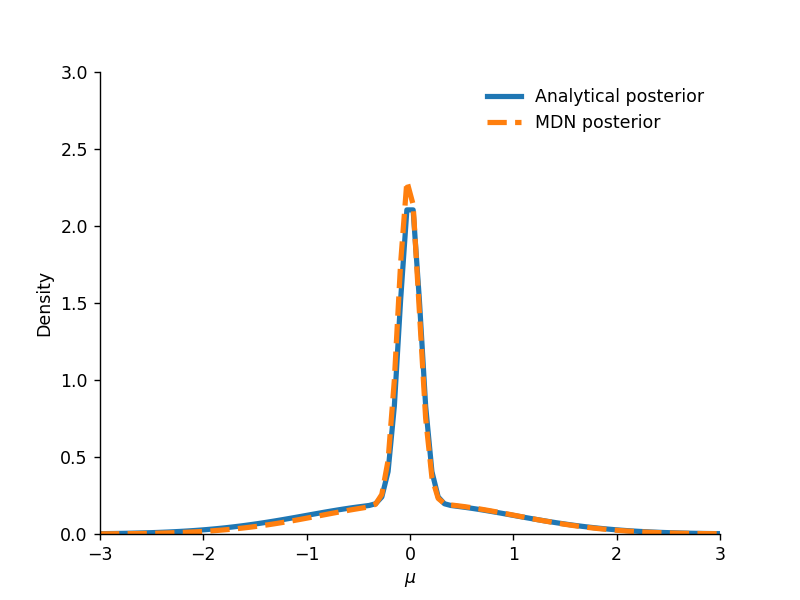

In [28]:
xx = np.linspace(-3,3,100)
f, ax = plt.subplots()
ax.plot(xx, posterior(xx), label='Analytical posterior', linewidth=3)
ax.plot(xx, pdf, label='MDN posterior', linewidth=3, linestyle='--')
ax.set_xlim((-3,3))
ax.set_ylim((0,3))
ax.legend(frameon=False)
ax.set_xlabel(r'$\mu$')
ax.set_ylabel('Density')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.savefig('regression_abc_gmm.pdf')

## Tuberculosis example
First, we initialize the Tuberculosis transmission rate example. Load the simulator and observed data, then read the reference (Rejection ABC) posterior.

In [16]:
alpha = 0.2
delta = 0
tau = 0.198
m = 20
N = 2e7

prior_alpha = acm2017_pyabc.Prior("uniform", 0.005, 2, name=r"$\alpha$")
#prior_tau = acm2017_pyabc.Prior("uniform", 0.01, 1, name="$\tau$")

list_of_priors = [prior_alpha]

simulator = lambda alpha: tuberculosis.simulator(alpha) if alpha >=0.005 else tuberculosis.simulator(0.005)

params = [alpha, tau, delta]

# 'test example' (observed data point)
y0 = np.array([6,3,2,2,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0]) # from paper
INPUT_DIM = 20
x_test = Variable(torch.from_numpy(np.array(y0).reshape(1, INPUT_DIM)).float())

# read reference (rejection ABC) posterior
rej = acm2017_pyabc.RejectionSampler.load('/home/dominik/Dropbox/Studium/AppliedCognitiveModelling2017/ABC/03 data/ex02/rej_10000_0.pkl')
rej.Thetas

xx = np.linspace(-0.2, 1.2, 100)

rej_thetas = rej.Thetas[:,0]
rej_kde = ss.kde.gaussian_kde(rej_thetas)
rej_dens = rej_kde(xx)

### Training the proposal prior
As Papamakarios & Murray (2016) note, learning the posterior directly while sampling from the prior is highly inefficient, since the posterior is learned for every $x$, not just for $x_0$. Thus, we first train a proposal prior, which is a one-dimensional Gaussian.

In [22]:
NHIDDEN = 50

proposal_mdn = MDN(hidden_size=NHIDDEN, num_mixtures=1, input_dim=INPUT_DIM)

<IPython.core.display.Javascript object>


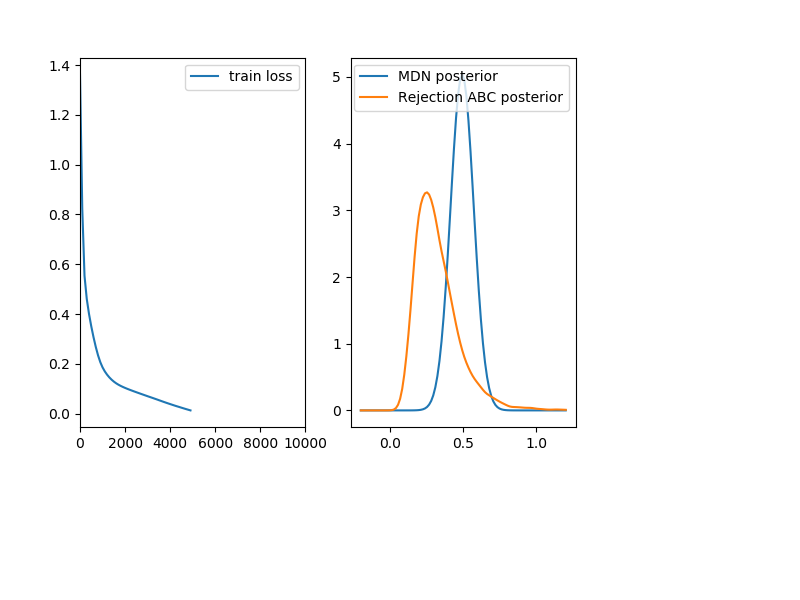

<IPython.core.display.Javascript object>


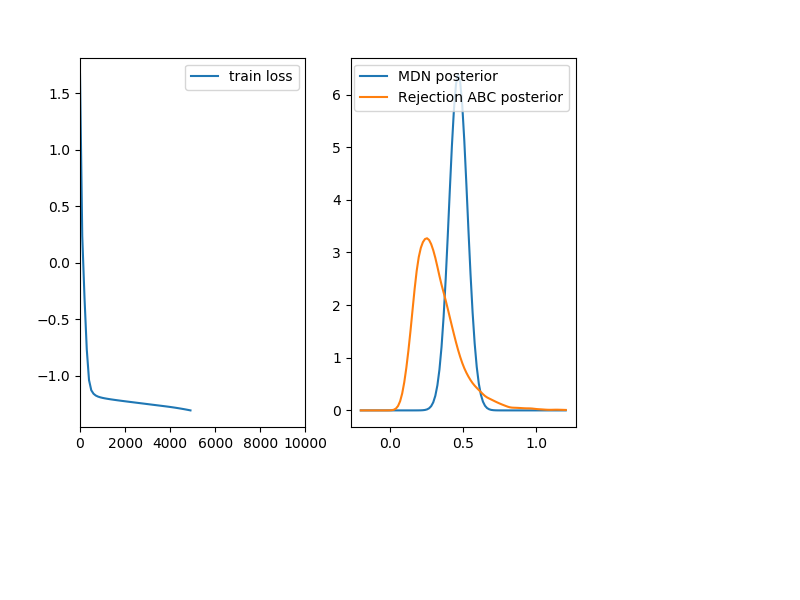

<IPython.core.display.Javascript object>


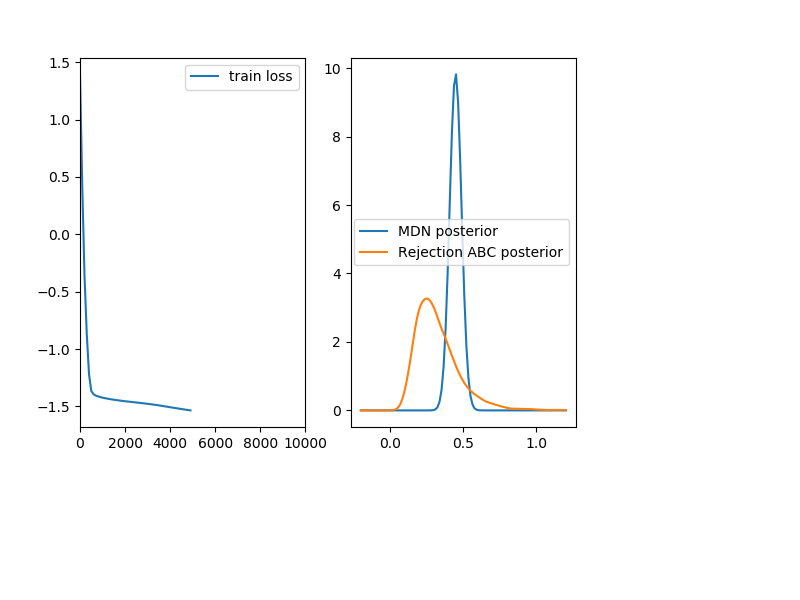

<IPython.core.display.Javascript object>


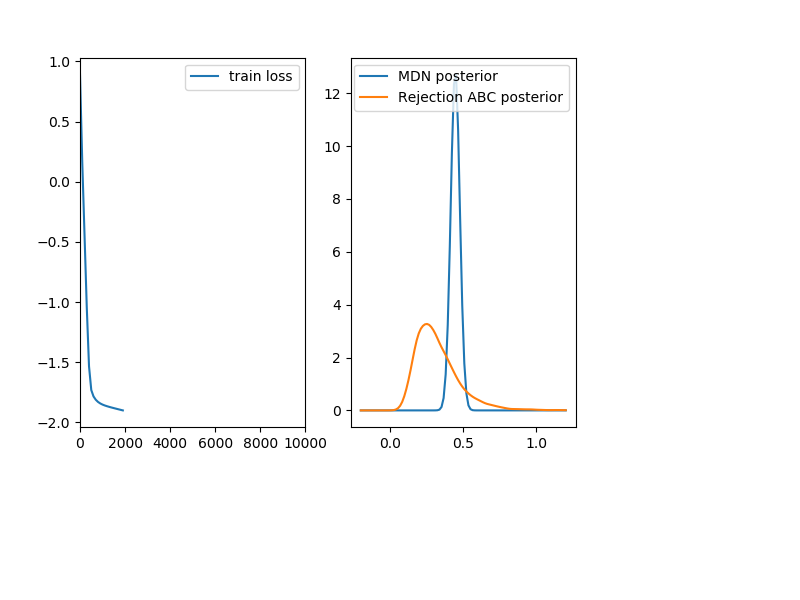

KeyboardInterrupt: 

In [25]:
# number of samples per iteration
NSAMPLE = 500

# create initial training set from prior
alpha_train = prior_alpha.sample(size=NSAMPLE)
x_train = np.array([simulator(float(alpha_i)) for alpha_i in alpha_train])

x_train = Variable(torch.from_numpy(x_train.reshape(NSAMPLE, INPUT_DIM)).float())
theta_train = Variable(torch.from_numpy(alpha_train.reshape(NSAMPLE, 1)).float(), requires_grad=False)





for i in range(5):
    f, (loss_ax, dens_ax) = plt.subplots(1,2)
    train_loss = []
    proposal_mdn = MDN(hidden_size=NHIDDEN, num_mixtures=1, input_dim=INPUT_DIM)
    #for i in range(5):
    learning_rate = 0.0001
    optimizer = torch.optim.Adam(proposal_mdn.parameters(), lr=learning_rate)
    for t in range(5_000):
        (out_pi, out_sigma, out_mu) = proposal_mdn(x_train)
        loss = mdn_loss_function(out_pi, out_sigma, out_mu, theta_train)        
        if (t % 100 == 0):
            train_loss.append(loss.data[0])
            loss_ax.cla()
            loss_ax.plot(np.arange(t+1, step=100), train_loss, label="train loss")
            loss_ax.set_xlim((0,10_000))
            loss_ax.legend()

            dens_ax.cla()
            dens_ax.plot(xx, proposal_mdn.pdf(x_test, xx), label='MDN posterior')
            dens_ax.plot(xx, rej_dens, label='Rejection ABC posterior')
            dens_ax.legend()

            f.canvas.draw()
            #print(t, loss.data[0])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # todo: analytical correction step!
    # or importance weighted loss function
    alpha_train = proposal_mdn.sample(x_test, n=NSAMPLE)
    x_train = np.array([simulator(float(alpha_i)) for alpha_i in alpha_train])

    x_train = Variable(torch.from_numpy(x_train.reshape(NSAMPLE, INPUT_DIM)).float())
    theta_train = Variable(torch.from_numpy(alpha_train.reshape(NSAMPLE, 1)).float(), requires_grad=False)

### Training without a proposal prior
For demonstration purposes, we train the model without using proposal priors

In [46]:
# create training set
NSAMPLE = 1000


# create training set
alpha_train = prior_alpha.sample(size=NSAMPLE)
x_train = np.array([simulator(float(alpha_i)) for alpha_i in alpha_train])

x_train = Variable(torch.from_numpy(x_train.reshape(NSAMPLE, INPUT_DIM)).float())
theta_train = Variable(torch.from_numpy(alpha_train.reshape(NSAMPLE, 1)).float(), requires_grad=False)

In [49]:
NHIDDEN = 50
KMIX = 1

model = MDN(hidden_size=NHIDDEN, num_mixtures=KMIX, input_dim=INPUT_DIM)

<IPython.core.display.Javascript object>


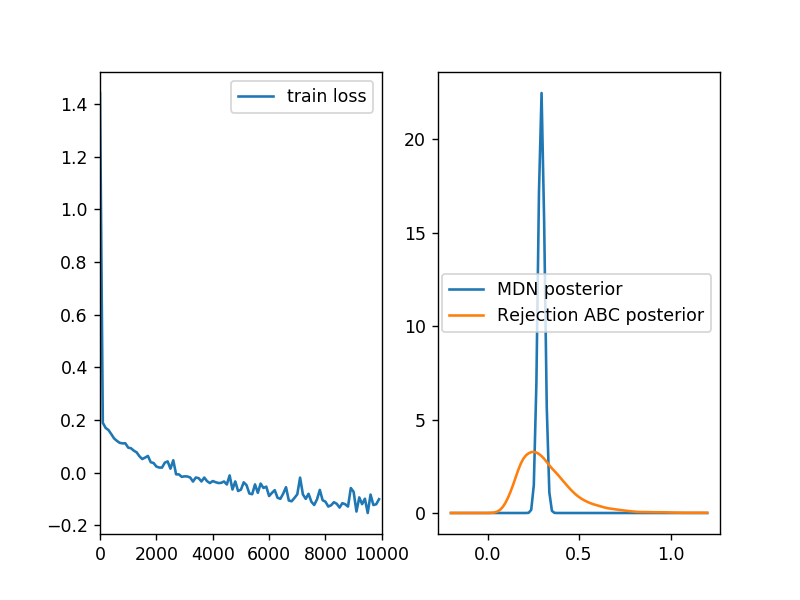

0 1.44171142578125
100 0.18936453759670258
200 0.16980941593647003
300 0.16195063292980194
400 0.1464022696018219
500 0.12998387217521667
600 0.12068553268909454
700 0.11330155283212662
800 0.1112627238035202
900 0.11135313659906387
1000 0.09511993825435638
1100 0.09263042360544205
1200 0.0835985392332077
1300 0.07715661823749542
1400 0.06219864264130592
1500 0.05168275535106659
1600 0.05725255236029625
1700 0.0635724812746048
1800 0.03967362269759178
1900 0.03673287481069565
2000 0.02321554720401764
2100 0.019432561472058296
2200 0.01923002116382122
2300 0.037930525839328766
2400 0.04286346212029457
2500 0.015055927447974682
2600 0.04709264636039734
2700 -0.006429240573197603
2800 -0.006448487285524607
2900 -0.015799731016159058
3000 -0.013981171883642673
3100 -0.014437421225011349
3200 -0.018359709531068802
3300 -0.03373294323682785
3400 -0.01834792271256447
3500 -0.020809851586818695
3600 -0.03333624079823494
3700 -0.018644198775291443
3800 -0.03236012160778046
3900 -0.0394887998700

In [50]:
f, (loss_ax, dens_ax) = plt.subplots(1,2)

learning_rate = 0.005
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
train_loss = []
for t in range(10_000):
    (out_pi, out_sigma, out_mu) = model(x_train)
    loss = mdn_loss_function(out_pi, out_sigma, out_mu, theta_train)        
    if (t % 100 == 0):
        train_loss.append(loss.data[0])
        loss_ax.cla()
        loss_ax.plot(np.arange(t+1, step=100), train_loss, label="train loss")
        loss_ax.set_xlim((0,10_000))
        loss_ax.legend()
        
        dens_ax.cla()
        dens_ax.plot(xx, model.pdf(x_test, xx), label='MDN posterior')
        dens_ax.plot(xx, rej_dens, label='Rejection ABC posterior')
        dens_ax.legend()
        
        f.canvas.draw()
        print(t, loss.data[0])
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

<IPython.core.display.Javascript object>


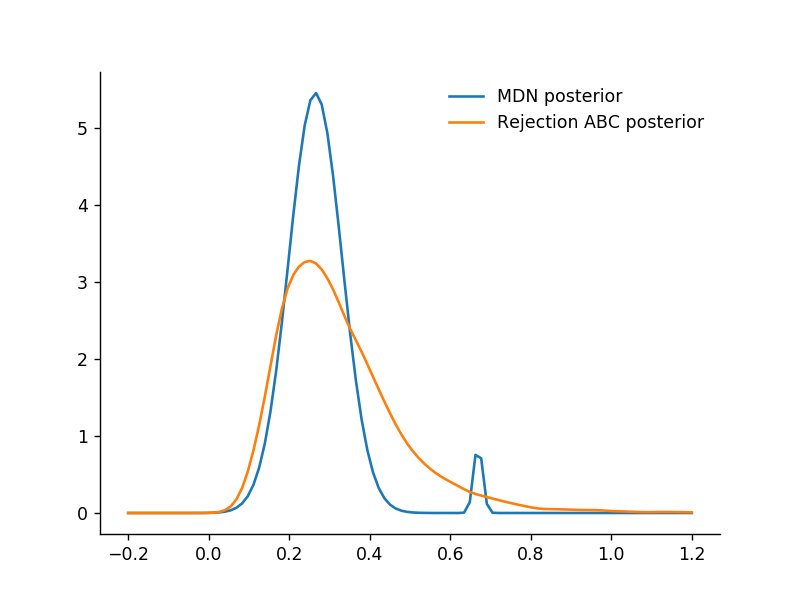

In [92]:
pdf = model.pdf(x_test, xx)

f, ax = plt.subplots()
ax.plot(xx, pdf, label='MDN posterior')
ax.plot(xx, rej_dens, label='Rejection ABC posterior')
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False) 
ax.legend(frameon=False)